In [1]:
import astropy.io.fits as fits
import numpy as np
from scipy.integrate import quad
import scipy.integrate as integrate
from scipy.optimize import curve_fit
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table, join
import os
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
import halomod as hm
import hmf
import treecorr

/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/halomod/halo_model.py:32: UserWarning: Warning: Some Halo-Exclusion models have significant speedup when using Numba
  from .halo_exclusion import NoExclusion


In [3]:
import DarkVerse as dv


In [4]:
home_dir = os.path.expanduser('~')
directory_SN_X3 = "/home/astro/manasoi7/Master_Thesis/Results/SN-X3"
directory_SN_C3 = "/home/astro/manasoi7/Master_Thesis/Results/SN-C3"
directory_SN_E2 = "/home/astro/manasoi7/Master_Thesis/Results/SN-E2" 
directory_COSMOS = "/home/astro/manasoi7/Master_Thesis/Results/COSMOS" 
res = os.path.join(home_dir, 'Master_Thesis', 'Results')

In [5]:

home_dir = os.path.expanduser('~')
thesis_path = os.path.join(home_dir, 'Master_Thesis', 'DATA')



# Catalog
fits_file_path = os.path.join(thesis_path, "Y3_deep_fields_DB_wKNN_cat_SN-C3_zm.fits")  
t= Table.read(fits_file_path)
masked_file_path = os.path.join(thesis_path, "SN-C3_masked_cat.fits")  
t3= Table.read(masked_file_path)

# Join in one table

t=join(t,t3,keys='id') 
t.rename_column('ra_1','ra')
t.rename_column('dec_1','dec')


# Load Randoms
fits_random = os.path.join(thesis_path, "SN-C3_randoms_ugriz_trim_video.fits") 
t2 = Table.read(fits_random)
randoms = t2  # Random catalog

# Define Correlation Function Configuration
config = {
    'min_sep': 0.003,
    'max_sep': 1.78,
    'bin_size': 0.1,
    'sep_units': 'degrees',
    'var_method': 'shot'   # if using the internal 'var_method': 'bootstrap' of treecrorr, but then it takes a long time to run
}







In [7]:
### USING SELECTION CLASS
sub = dv.Selection(t, randoms, 0.4, 0.6, 10, 12.5, config)    # if i put the upper limit at 12.5 logSM then it is considered open-ended

# Fit HOD with custom bounds
hod_params, pcov = sub.fit_hod()

results = sub.get_results()

logM_min, logM_1, alpha = results['hod_params']
print(f"HOD fit results: M_min = 10^{logM_min:.2f}, "
      f"M_1 = 10^{logM_1:.2f}, alpha = {alpha:.2f}")

HOD fit results: M_min = 10^0.00, M_1 = 10^12.64, alpha = 0.79


## HOD fit results: M_min = 10^12.50, M_1 = 10^13.72, alpha = 0.94




### WITHOUT BOOTSTRAP

<Figure size 1000x800 with 0 Axes>

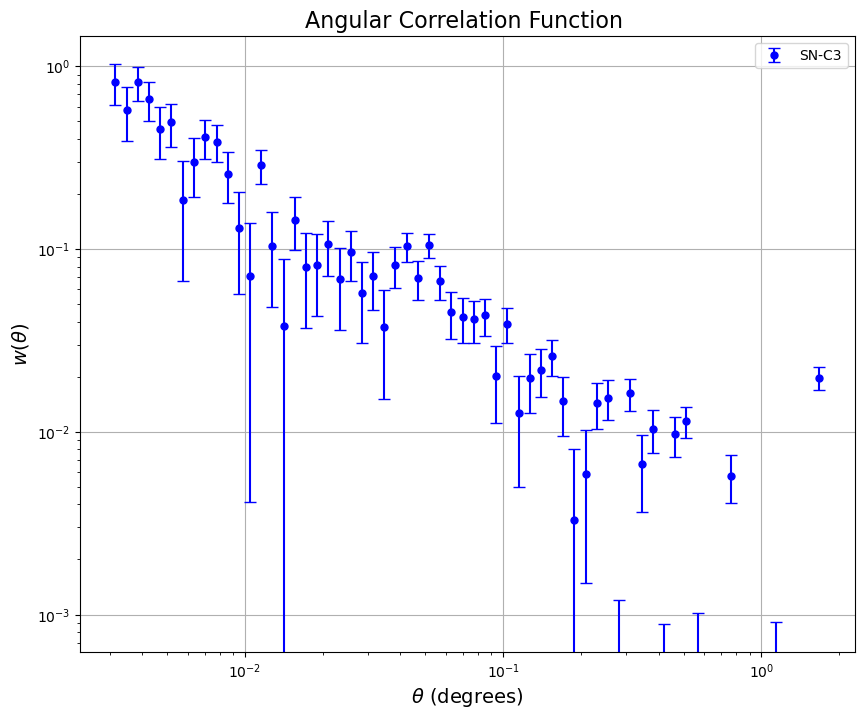

In [8]:
plt.figure(figsize=(10, 8))

theta = results['theta']
w_obs = results['w_theta']
var_w_obs= results['var_w_theta'] #shot noise Shot noise or Poisson noise is a type of noise which can be modeled by a Poisson process.


w_err = np.sqrt(var_w_obs)



plt.figure(figsize=(10, 8))
plt.errorbar(theta, w_obs, yerr= w_err, fmt='o', color='blue', label= 'SN-C3', capsize=4, markersize=5)

plt.xlabel(r'$\theta$ (degrees)', fontsize=14)
plt.ylabel(r'$w(\theta)$', fontsize=14)
plt.title('Angular Correlation Function ', fontsize=16)

plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.grid(True)
plt.show()

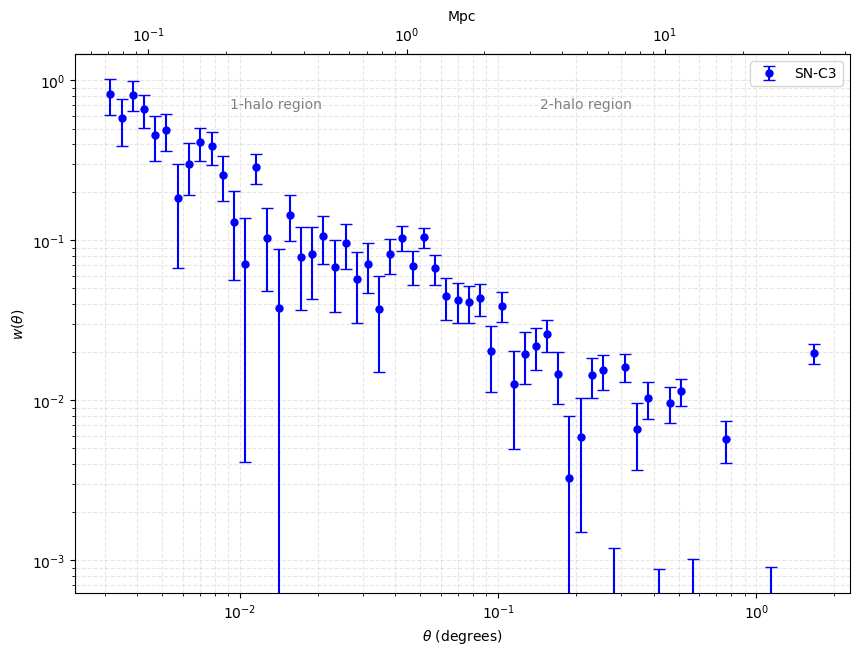

In [9]:
from astropy.cosmology import Planck15
plt.rcParams['text.usetex'] = False


z_mean = 0.5 


fig = plt.figure(figsize=[10,7])
ax = fig.add_subplot(111)
ax.errorbar(theta, w_obs, yerr= w_err, fmt='o', color='blue',label= 'SN-C3', capsize=4, markersize=5)
#ax.plot(theta, w_model, label='Best-fit HOD Model', color='red')

ax.set_xlabel(r'$\theta$ (degrees)')
ax.set_ylabel(r'$w(\theta)$')
#ax.set_title('Plot with Gaussian errors' )
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_ylim([1e-4,10.])
#ax.set_xlim([8e-4,2.])
ax.text(0.2, 0.9, "1-halo region", transform=plt.gca().transAxes, color='gray')
ax.text(0.6, 0.9, "2-halo region", transform=plt.gca().transAxes, color='gray')
secax = ax.secondary_xaxis('top',functions=(lambda x: x*Planck15.kpc_proper_per_arcmin(z_mean).value*60./1e3,
                                   lambda x: x*Planck15.arcsec_per_kpc_proper(z_mean).value*1e3/3.6e3))
secax.set_xlabel(r'Mpc')
#ax.grid(True)
ax.grid(True, which="both", ls="--", alpha=0.3)



#y_at_1_degree = w_t(A_median, power_median, 1, mask_rr)
#ax.axhline(w_t(A_median, power_median, 1, mask_rr), color='r', linestyle='--', label='Model at 1 deg')



ax.legend()

### WITH BOOTSTRAP

<Figure size 1000x800 with 0 Axes>

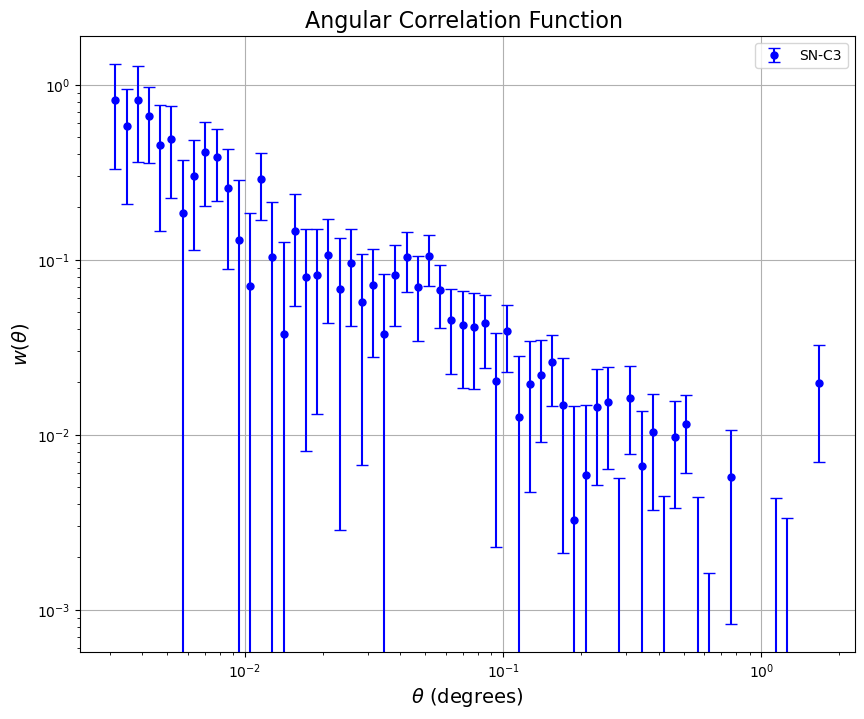

In [10]:
plt.figure(figsize=(10, 8))

theta = results['theta']
w_obs = results['w_theta']
var_w_obs= results['var_w_theta_bootstrap']

w_err = np.sqrt(var_w_obs)



plt.figure(figsize=(10, 8))
plt.errorbar(theta, w_obs, yerr= w_err, fmt='o', color='blue',label= 'SN-C3', capsize=4, markersize=5)

plt.xlabel(r'$\theta$ (degrees)', fontsize=14)
plt.ylabel(r'$w(\theta)$', fontsize=14)
plt.title('Angular Correlation Function ', fontsize=16)

plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.grid(True)
plt.show()

## Model prediction with best-fit parameters

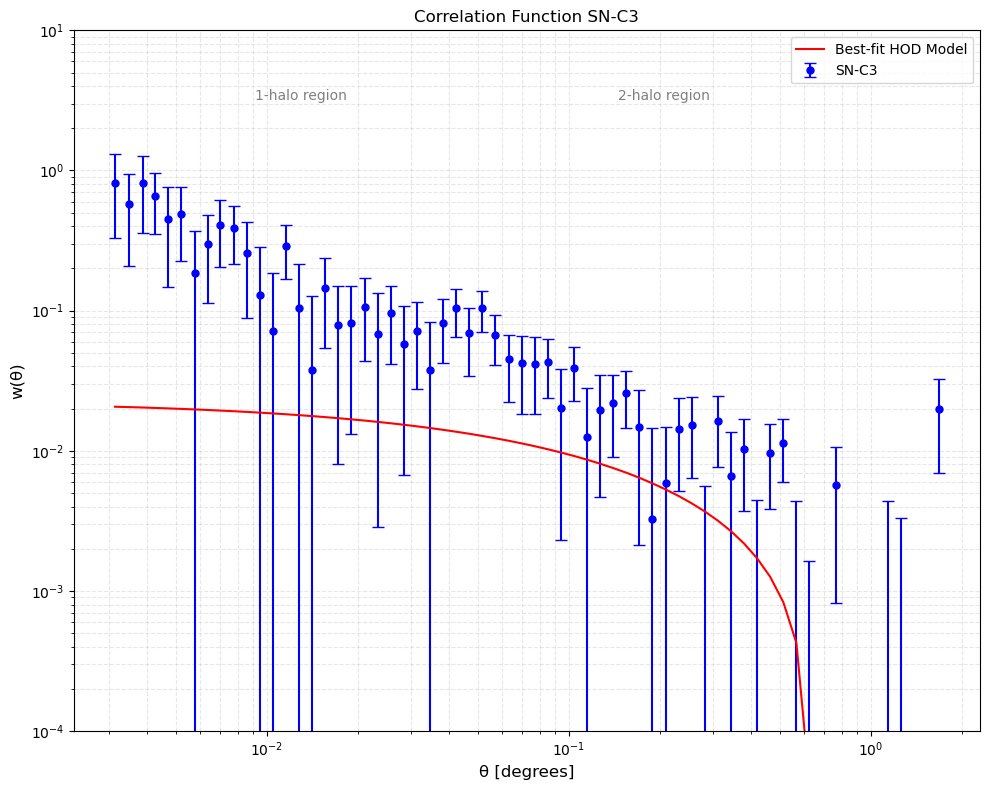

In [11]:

xi_m_values = results['xi_m']

# Model prediction with best-fit parameters
logM_min, logM_1, alpha = results['hod_params']
w_model = sub.hod_model(logM_min, logM_1, alpha) 

plt.figure(figsize=(10, 8))

plt.errorbar(theta, w_obs, yerr= w_err, fmt='o', color='blue', label= 'SN-C3',capsize=4, markersize=5)
plt.plot(theta, w_model, label='Best-fit HOD Model', color='red')
#plt.plot(theta, xi_m_values, label=r'$\w_{dm}(\theta)$ (Matter-Matter)', linestyle='dashed', color='black')


plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-4,10.])

plt.xlabel('θ [degrees]', fontsize=12)
plt.ylabel('w(θ)', fontsize=12)
plt.title(f'Correlation Function SN-C3')
plt.legend(fontsize=10, framealpha=0.8)
plt.grid(True, which="both", ls="--", alpha=0.3)

# Add annotations
plt.text(0.2, 0.9, "1-halo region", transform=plt.gca().transAxes, color='gray')
plt.text(0.6, 0.9, "2-halo region", transform=plt.gca().transAxes, color='gray')


plt.tight_layout()
plt.show()


In [12]:


one_halo = sub.gg.corr_1h_auto_matter *0.002
two_halo =sub.gg.corr_2h_auto_matter*0.007
w_m= sub.gg.angular_corr_matter
w_g = sub.gg.angular_corr_gal


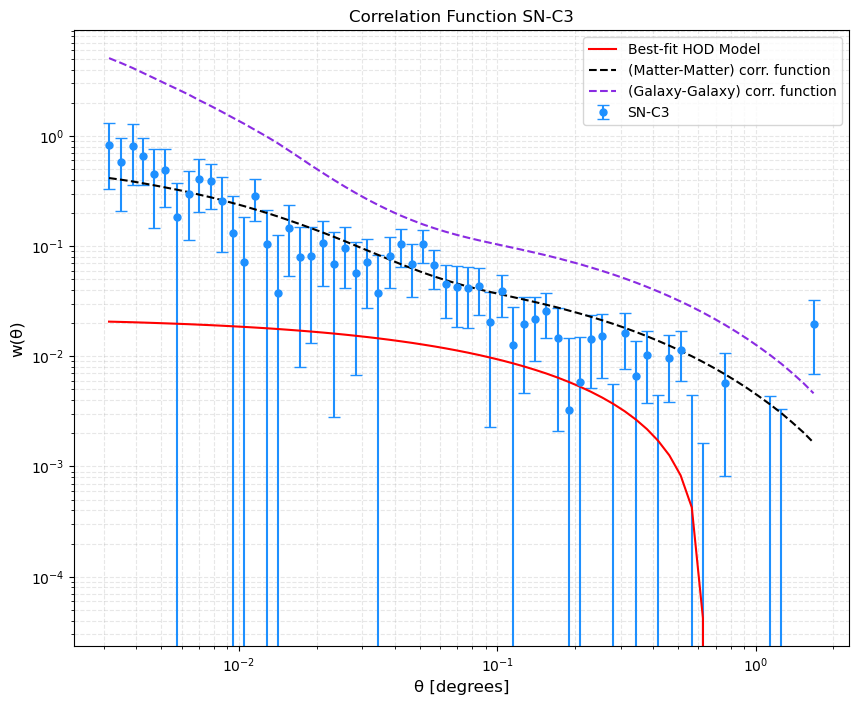

In [14]:
xi_m_values = results['xi_m']
xi_g_values = results['xi_g']


# Model prediction with best-fit parameters
logM_min, logM_1, alpha = results['hod_params']
w_model = sub.hod_model(logM_min, logM_1, alpha) 

plt.figure(figsize=(10, 8))

plt.errorbar(theta, w_obs, yerr= w_err, fmt='o', color='dodgerblue', label= 'SN-C3',capsize=4, markersize=5)
plt.plot(theta, w_model, label='Best-fit HOD Model', color='red')
plt.plot(theta, xi_m_values, label=r'(Matter-Matter) corr. function', linestyle='dashed', color='black')
plt.plot(theta, xi_g_values, label=r'(Galaxy-Galaxy) corr. function', linestyle='dashed', color='blueviolet')


plt.xscale('log')
plt.yscale('log')
#plt.ylim([1e-4, 10.])
plt.xlabel('θ [degrees]', fontsize=12)
plt.ylabel('w(θ)', fontsize=12)
plt.title('Correlation Function SN-C3')

plt.legend(fontsize=10, framealpha=0.8)
plt.grid(True, which="both", ls="--", alpha=0.3)

plt.show()


from astropy.cosmology import Planck15
plt.rcParams['text.usetex'] = False


z_mean = 0.5 


fig = plt.figure(figsize=[10,7])
ax = fig.add_subplot(111)
ax.errorbar(theta, w_obs, yerr= w_err, fmt='o', color='blue', capsize=4, markersize=5)
ax.plot(theta, w_model, label='Best-fit HOD Model', color='red')

ax.set_xlabel(r'$\theta$ (degrees)')
ax.set_ylabel(r'$w(\theta)$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-4,10.])
ax.set_xlim([8e-4,2.])
secax = ax.secondary_xaxis('top',functions=(lambda x: x*Planck15.kpc_proper_per_arcmin(z_mean).value*60./1e3,
                                   lambda x: x*Planck15.arcsec_per_kpc_proper(z_mean).value*1e3/3.6e3))
secax.set_xlabel(r'Mpc')
ax.grid(True)


#y_at_1_degree = w_t(A_median, power_median, 1, mask_rr)
#ax.axhline(w_t(A_median, power_median, 1, mask_rr), color='r', linestyle='--', label='Model at 1 deg')



ax.legend()

## ^what is going on in the middle ???

In [15]:
bias_eff = sub.gg.bias_effective_tracer #The tracer occupation-weighted halo bias factor (Tinker 2005).
print(f"Effective galaxy bias: {bias_eff:.3f}")


Effective galaxy bias: 0.593


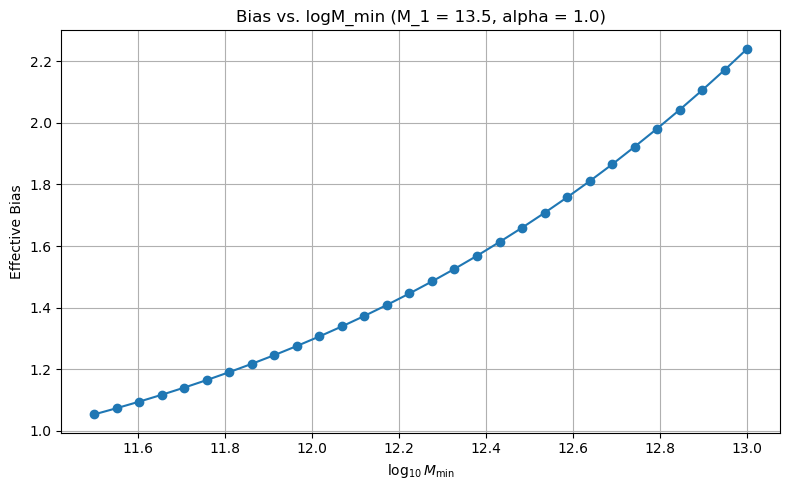

In [16]:
logM_1_fixed = 13.5
alpha_fixed = 1.0

logM_min_vals = np.linspace(11.5, 13.0, 30)
bias_vals = []

for logM_min in logM_min_vals:
    sub.hod_model(logM_min, logM_1_fixed, alpha_fixed)
    bias = sub.gg.bias_effective_tracer
    bias_vals.append(bias)

plt.figure(figsize=(8, 5))
plt.plot(logM_min_vals, bias_vals, marker='o')
plt.xlabel(r"$\log_{10} M_{\mathrm{min}}$")
plt.ylabel("Effective Bias")
plt.title("Bias vs. logM_min (M_1 = 13.5, alpha = 1.0)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:
mask = (theta >= 0.1) & (theta <= 0.4)

bias_estimator = dv.BiasEstimator(
    xi_g=results['xi_g'],
    xi_m=results['xi_m'],
    w_theta_list= w_obs,
    w_theta_error_list=w_err,
    sum_rr_list=[results['rr_counts']],
    mask=mask
)

bias_values, bias_errors = bias_estimator.estimate_bias()
print("Bias values:", bias_values)
print("Bias errors:", bias_errors)


Bias values: [1.2753934822118258]
Bias errors: [0.04438119774213996]


# Now trying all my fields and different redshift bins using Selection class that finds the best fit for my 3 HOD parameters

In [39]:
home_dir = os.path.expanduser('~')
thesis_path = os.path.join(home_dir, 'Master_Thesis', 'DATA')

# Field details
fields = {
    "SN-X3": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-X3_zm.fits",
        "masked": "SN-X3_masked_cat.fits",
        "randoms": "SN-X3_randoms_ugriz_trim_video.fits"
    },
    "SN-C3": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-C3_zm.fits",
        "masked": "SN-C3_masked_cat.fits",
        "randoms": "SN-C3_randoms_ugriz_trim_video.fits"
    },
    "SN-E2": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-E2_zm.fits",
        "masked": "SN-E2_masked_cat.fits",
        "randoms": "SN-E2_randoms_ugriz_trim_video.fits"
    },
    "COSMOS": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_COSMOS_zm.fits",
        "masked": "COSMOS_masked_cat.fits",
        "randoms": "COSMOS_randoms_ugriz_trim_video.fits"
    }
}

config = {
    'min_sep': 0.003,
    'max_sep': 1.78,
    'bin_size': 0.1,
    'sep_units': 'degrees',
    'var_method': 'shot'
}

SM_min, SM_max = 10, 12.5  # High SM
z_ranges = [(0.0, 0.2),(0.2, 0.4), (0.4, 0.6),(0.6, 0.8), (0.8,1.0)]
colors = ["blue", "green", "red", "purple", "orange"]  # Different color for each redshift bin


# Initialize storage for all results
all_results = {z_range: {} for z_range in z_ranges}

# Process each redshift range
for z_min, z_max in z_ranges:
    print(f"\n\n🔹 Processing redshift range {z_min}-{z_max}")
    
    # Initialize bias estimator for this redshift range (using first field as reference)
    first_field = list(fields.keys())[0]
    first_catalog = Table.read(os.path.join(thesis_path, fields[first_field]["catalog"]))
    first_masked = Table.read(os.path.join(thesis_path, fields[first_field]["masked"]))
    first_catalog = join(first_catalog, first_masked, keys='id')
    first_catalog.rename_columns(['ra_1', 'dec_1'], ['ra', 'dec'])
    first_randoms = Table.read(os.path.join(thesis_path, fields[first_field]["randoms"]))
    
    first_subsample = dv.Selection(
        catalog=first_catalog,
        randoms=first_randoms,
        z_min=z_min,
        z_max=z_max,
        SM_min=SM_min,
        SM_max=SM_max,
        config=config
    )
    first_results = first_subsample.get_results()
    
    estimator = dv.FieldBiasEstimator(
        xi_m=np.array(first_results['xi_m']),
        mask=(np.array(first_results['theta']) >= 0.1) & (np.array(first_results['theta']) <= 0.4)
    )
    
    bias_eff_dict = {}

    # Process each field for this redshift range
    for field, paths in fields.items():
        print(f"\n🔸 Processing field: {field}")
        
        # Load data
        catalog = Table.read(os.path.join(thesis_path, paths["catalog"]))
        masked = Table.read(os.path.join(thesis_path, paths["masked"]))
        catalog = join(catalog, masked, keys='id')
        catalog.rename_columns(['ra_1', 'dec_1'], ['ra', 'dec'])
        randoms = Table.read(os.path.join(thesis_path, paths["randoms"]))
        
        # Compute subsample
        subsample = dv.Selection(
            catalog=catalog,
            randoms=randoms,
            z_min=z_min,
            z_max=z_max,
            SM_min=SM_min,
            SM_max=SM_max,
            config=config
        )

        hod_params, pcov = subsample.fit_hod()

        results = subsample.get_results()
        
        # Get effective bias from gg
        bias_eff = subsample.gg.bias_effective_tracer
        bias_eff_dict[field] = bias_eff
        print(f"  ➤ bias_eff = {bias_eff:.3f}")

        logM_min, logM_1, alpha = results['hod_params']
        print(f"HOD fit results: M_min = 10^{logM_min:.2f}, "
              f"M_1 = 10^{logM_1:.2f}, alpha = {alpha:.2f}")
        
        # Add to estimator
        estimator.add_field(
            field_name=field,
            xi_g=np.array(results['xi_g']),
            w_theta=np.array(results['w_theta']),
            w_theta_error=np.sqrt(np.array(results['var_w_theta_bootstrap'])),  # Using bootstrap errors
            sum_rr=np.array(results['rr_counts'])
        )
    
    # 1. Fit individual fields
    print("\nIndividual Field Results:")
    individual_results = estimator.fit_individual_fields()
    for name, b, be, ic in individual_results:
        print(f"{name}: b = {b:.3f} ± {be:.3f}, IC = {ic:.4f}")
    
    # 2. Get combined bias estimate
    global_b, global_be = estimator.fit_combined()
    print(f"\nGlobal bias estimate: {global_b:.3f} ± {global_be:.3f}")
    
    # 3. Store results
    all_results[(z_min, z_max)] = {
        'individual': individual_results,
        'global_b': global_b,
        'global_be': global_be,
        'estimator': estimator,
        'bias_eff': bias_eff_dict  # per-field biases
    }

    




🔹 Processing redshift range 0.0-0.2
The following patch numbers have no objects: {1, 2, 33, 34, 5, 37, 9, 44, 13, 15, 18, 20, 22, 27, 31}
This may be a problem depending on your use case.
The following patch numbers have no objects: {33, 2, 35, 10, 11, 17, 49, 19, 20, 24, 26, 27, 30}
This may be a problem depending on your use case.
The following patch numbers have no objects: {2, 37, 7, 8, 40, 42, 12, 45, 47, 48, 20, 22, 24, 26, 30}
This may be a problem depending on your use case.
The following patch numbers have no objects: {2, 4, 37, 6, 8, 42, 11, 44, 47, 16, 23, 25, 26, 29, 30}
This may be a problem depending on your use case.
The following patch numbers have no objects: {1, 2, 3, 37, 7, 43, 45, 47, 49, 20, 22, 30, 31}
This may be a problem depending on your use case.
The following patch numbers have no objects: {1, 3, 35, 6, 8, 41, 11, 43, 15, 47, 17, 49, 22, 25, 31}
This may be a problem depending on your use case.
The following patch numbers have no objects: {1, 3, 36, 5, 38,

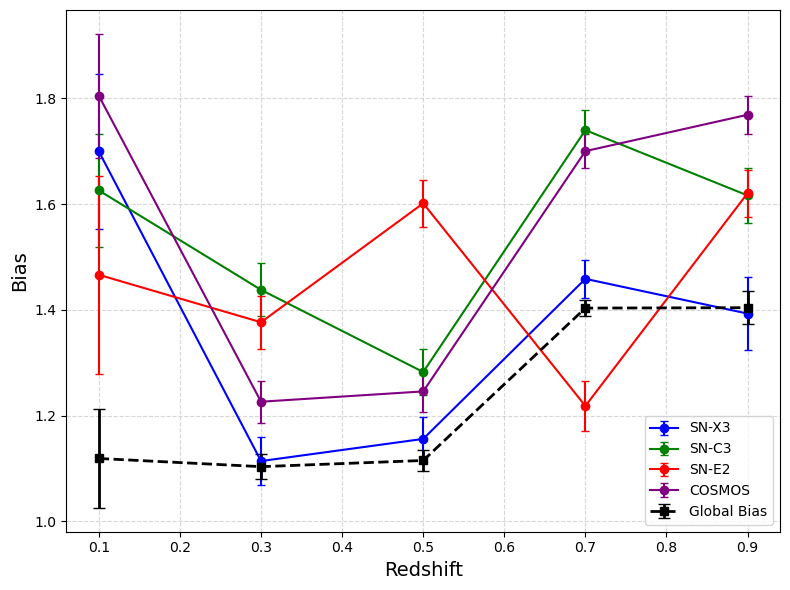

In [40]:
plt.figure(figsize=(8, 6))

colors = ["blue", "green", "red", "purple", "orange"]  # Different color for each redshift bin


# Set up redshift bin centers
z_centers = [(zmin + zmax) / 2 for (zmin, zmax) in z_ranges]

# Collect field names
field_names = list(fields.keys())

# Initialize storage
field_biases = {field: [] for field in field_names}
field_errors = {field: [] for field in field_names}
global_biases = []
global_errors = []
eff_biases = []

# Fill in the data from all_results dictonnary
for z_bin in z_ranges:
    results = all_results[z_bin]['individual']
    global_b = all_results[z_bin]['global_b']
    global_be = all_results[z_bin]['global_be']
    
    result_dict = {name: (b, be) for name, b, be, _ in results}
    for field in field_names:
        b, be = result_dict.get(field, (None, None))
        field_biases[field].append(b)
        field_errors[field].append(be)

    global_biases.append(global_b)
    global_errors.append(global_be)
    biases_eff.append(bias_eff)

# Plot individual field biases
for i, field in enumerate(field_names):
    plt.errorbar(z_centers,field_biases[field],yerr=field_errors[field],label=field,color=colors[i],marker='o',capsize=3,linestyle='-')

# Now plot effective bias per field
for i, field in enumerate(field_names):
    eff_biases = []
    for z_bin in z_ranges:
        bias_eff_dict = all_results[z_bin]['bias_eff']
        eff_bias = bias_eff_dict.get(field, None)
        eff_biases.append(eff_bias)

    #plt.plot( z_centers,eff_biases,color=colors[i],linestyle=':',linewidth=2,marker='x',label=f"{field} (eff)")


# Plot global bias
plt.errorbar(z_centers,global_biases,yerr=global_errors,label='Global Bias',color='black',marker='s',linestyle='--',capsize=4,linewidth=2)




plt.xlabel("Redshift", fontsize=14)
plt.ylabel("Bias", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig(os.path.join(res,"Bias_eff_vs_z_for_High_SM.png"))

plt.legend()
plt.tight_layout()
plt.show()

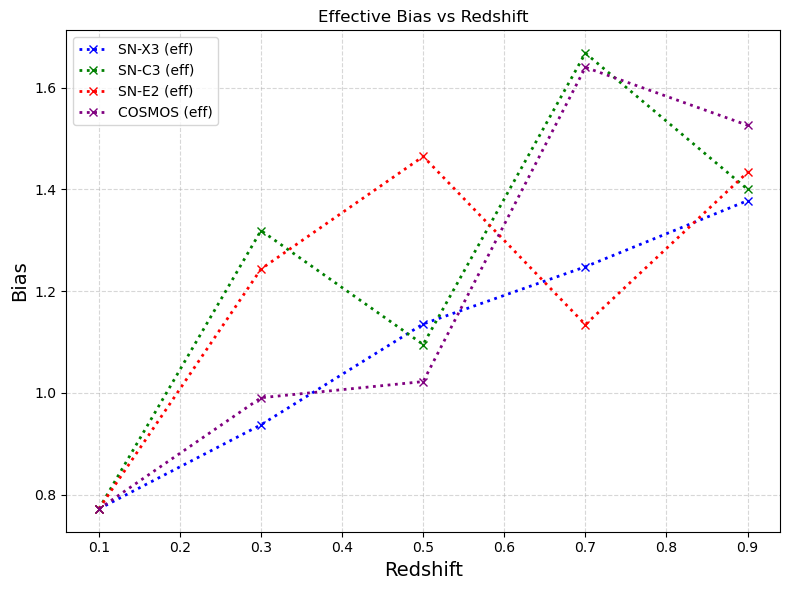

In [41]:
plt.figure(figsize=(8, 6))

colors = ["blue", "green", "red", "purple", "orange"]  # Different color for each redshift bin


# Set up redshift bin centers
z_centers = [(zmin + zmax) / 2 for (zmin, zmax) in z_ranges]

# Collect field names
field_names = list(fields.keys())

# Initialize storage
field_biases = {field: [] for field in field_names}
field_errors = {field: [] for field in field_names}
global_biases = []
global_errors = []
eff_biases = []

# Fill in the data from all_results dictonnary
for z_bin in z_ranges:
    results = all_results[z_bin]['individual']
    global_b = all_results[z_bin]['global_b']
    global_be = all_results[z_bin]['global_be']
    
    result_dict = {name: (b, be) for name, b, be, _ in results}
    for field in field_names:
        b, be = result_dict.get(field, (None, None))
        field_biases[field].append(b)
        field_errors[field].append(be)

    global_biases.append(global_b)
    global_errors.append(global_be)
    biases_eff.append(bias_eff)

# Plot individual field biases
#for i, field in enumerate(field_names):
    #plt.errorbar(z_centers,field_biases[field],yerr=field_errors[field],label=field,color=colors[i],marker='o',capsize=3,linestyle='-')

# Now plot effective bias per field
for i, field in enumerate(field_names):
    eff_biases = []
    for z_bin in z_ranges:
        bias_eff_dict = all_results[z_bin]['bias_eff']
        eff_bias = bias_eff_dict.get(field, None)
        eff_biases.append(eff_bias)

    plt.plot(
        z_centers,
        eff_biases,
        color=colors[i],
        linestyle=':',
        linewidth=2,
        marker='x',
        label=f"{field} (eff)"
    )


# Plot global bias
#plt.errorbar(z_centers,global_biases,yerr=global_errors,label='Global Bias',color='black',marker='s',linestyle='--',capsize=4,linewidth=2)




plt.xlabel("Redshift", fontsize=14)
plt.ylabel("Bias", fontsize=14)
plt.title("Effective Bias vs Redshift")
plt.grid(True, linestyle='--', alpha=0.5)

plt.legend()
plt.tight_layout()
plt.show()